# 확장 칼만 필터
- 칼만필터는 선형시스템을 가정하고 개발되었기 때문에, 실생활에 존재하는 대부분의 비선형 시스템에는 적용 제한
- 확장칼만필터(Extended Kalman Filter, EKF) : 비선형 시스템까지 확산가능
- EKF의 단점 : 알고리즘이 발산할 위험 있음 (이후 개발되는 필터는 이를 보완하기 위함)

## 선형화 칼만필터
- [그림 4-1]의 선형칼만필터 알고리즘과 동일

### 선형화 칼만필터와 선형 칼만필터의 차이
- 선형칼만필터의 시스템모델은 원래부터 선형
- 선형화 칼만필터는 비선형시스템을 하나의 기준점 주위에서 선형화 시켜 얻은 선형모델 A와 H 사용
- 두 경우 모두 칼만필터의 설계과정은 같으므로 설계에 있어 특별한 주의사항은 없음

### 선형화 칼만필터를 실제 시스템에 적용 시 유의사항
- 시스템의 운용범위에 각별히 유의해야 함
- 선형화모델은 기준점 주위에서만 실제시스템과 비슷한 특성 보이므로, 해당 범위 벗어나면 신뢰성 떨어짐
- 위의 한계를 무시하면, 제대로 된 성능 내지 못하고 시스템이 발산할 가능성 있음
- 선형화칼만필터의 핵심요소는 비선형 시스템의 선형화 모델

## EKF 알고리즘

### 비선형 시스템모델
- 선형모델과 비교했을 때, 상태변수(xk)와 계수를 따로 분리해서 쓰지 못한다는 특징 있음

### EKF 알고리즘
- 전체과정은 동일하지만, 단계별 수식에서 차이가 있음

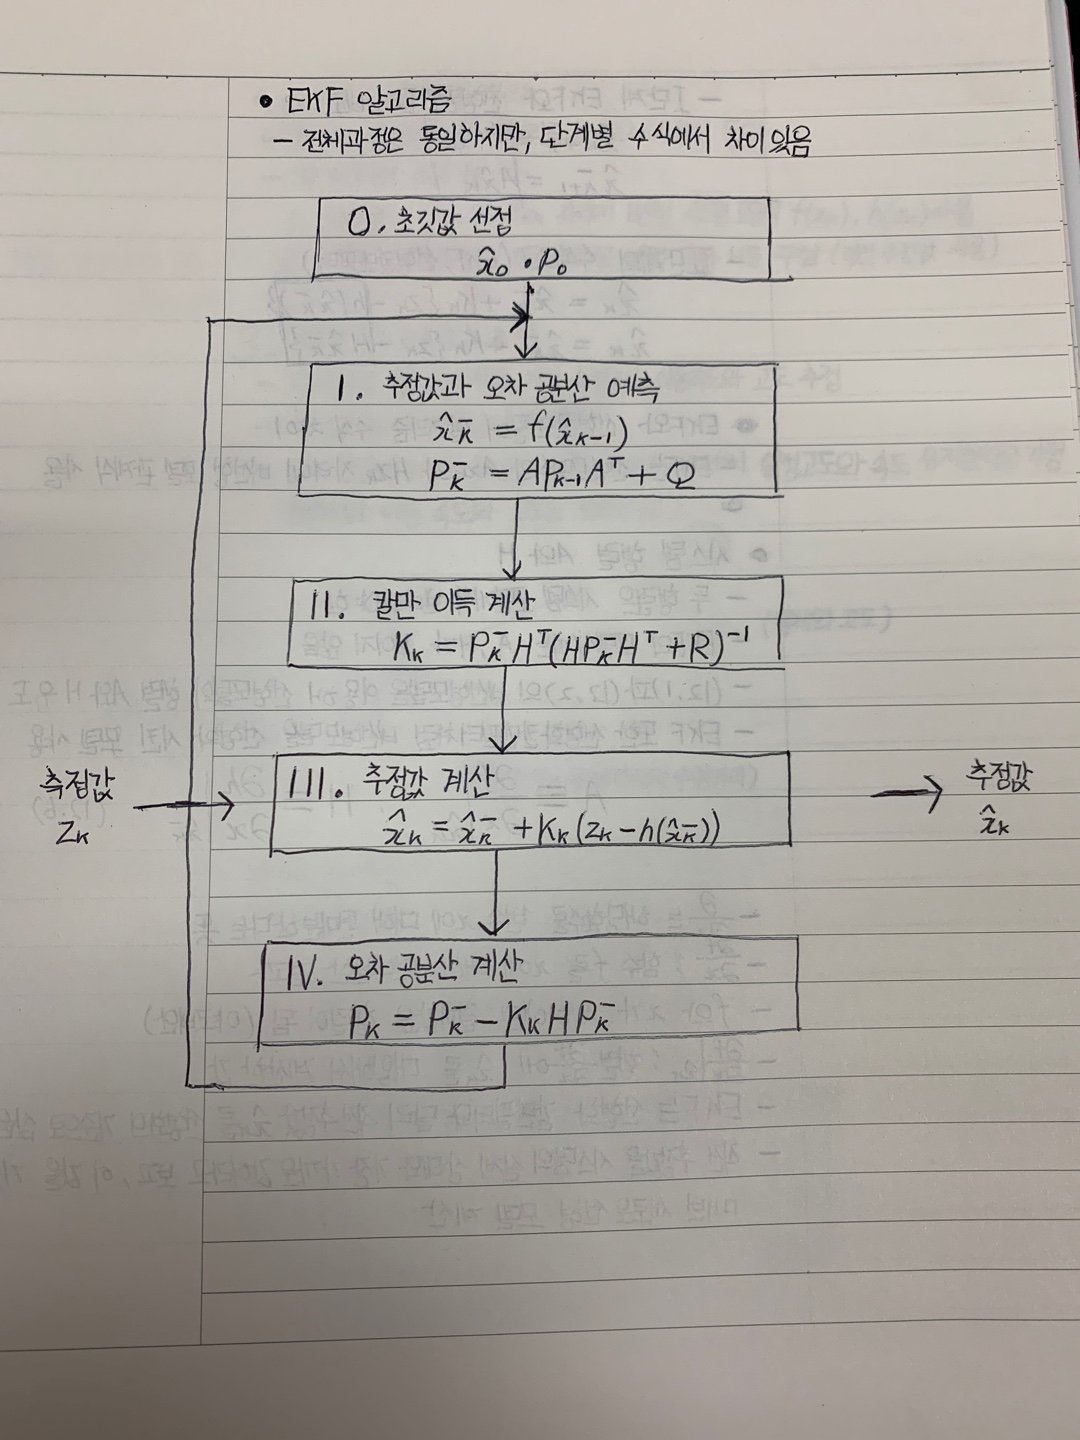

In [1]:
from PIL import Image
Image.open('./image/ch12_1.jpeg')

### EKF와 선형칼만필터 알고리즘 수식 차이
- EKF는 선형모델식의 Axk와 Hxk자리에 비선형 모델 관계식 사용

### 시스템 행렬 A와 H
- 두 행렬은 시스템 모델에서 받아와야 함
- EKF의 모델식에는 A,H가 보이지 않음
- 식(12.1)과 (12.2)의 비선형모델 이용하여 선형모델의 행렬 A와 H 유도
- EKF 또한 선형화칼만필터처럼 비선형모델을 선형화 시킨 모델 사용

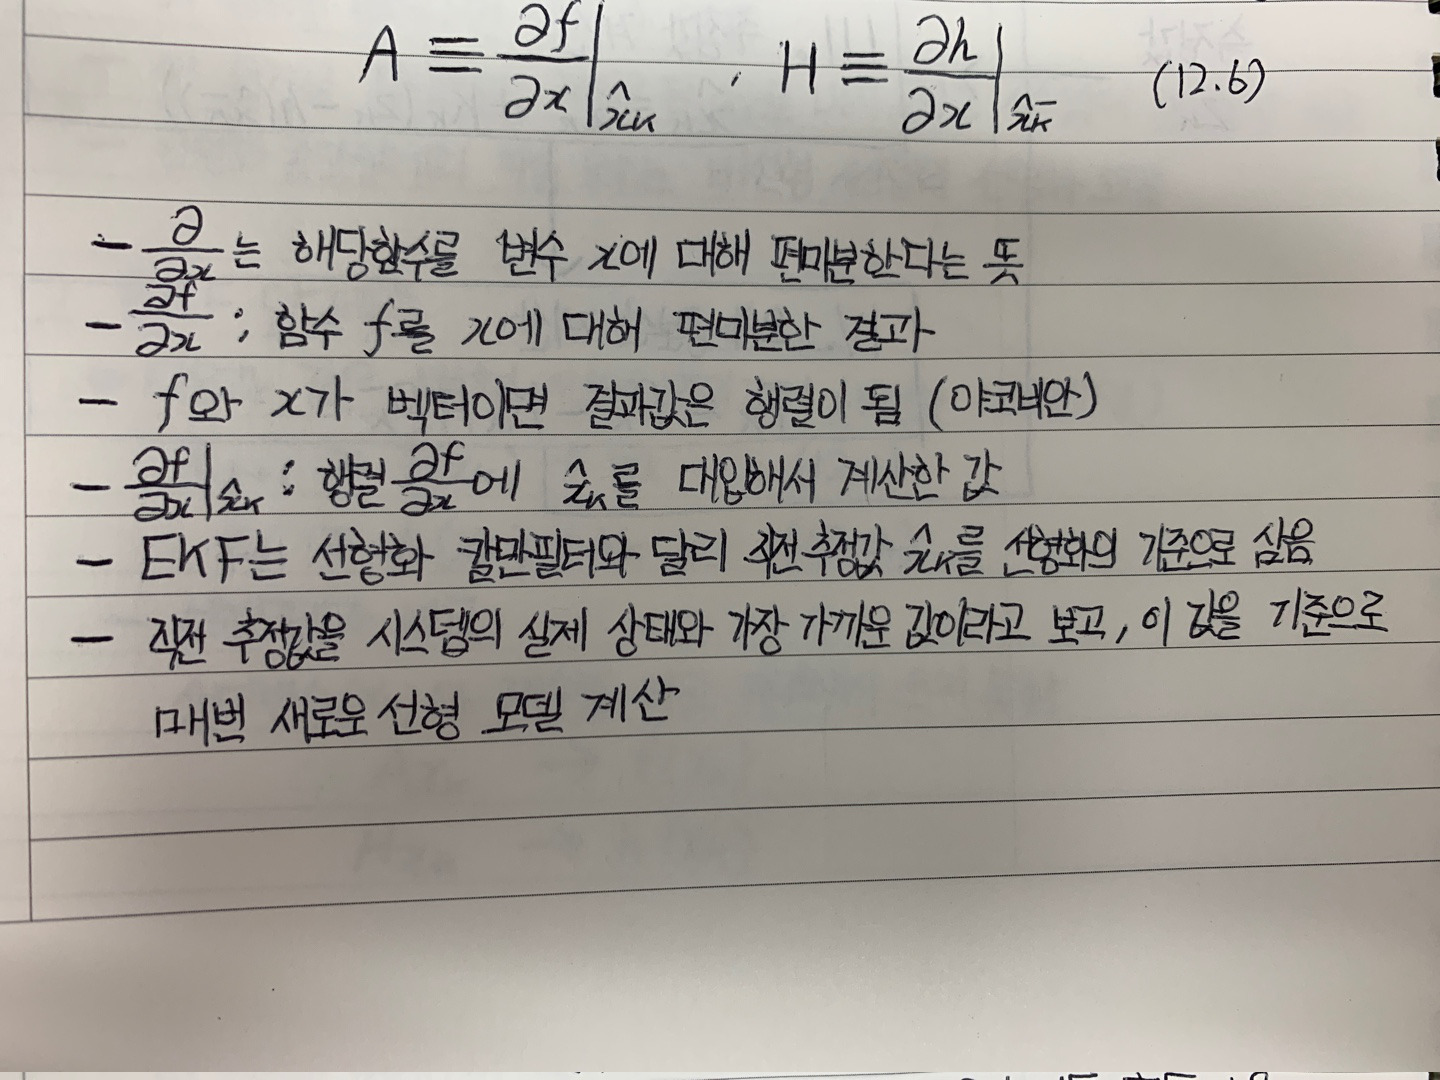

In [3]:
Image.open('./image/ch12_2.jpeg')

### EKF 알고리즘 설명 정리
- EKF는 선형칼만필터 알고리즘과 전체과정이 동일
- 각 단계별 차이점
    1. 선형모델식 Axk와 Hxk 자리에 비선형 시스템 모델식 f(xk), h(xk) 사용
    2. EKF는 비선형모델의 야코비안으로 행렬 A와 H를 구함 (직전추정값 사용)
    
## 예제 1 : 레이다 추적
- 레이다로 물체까지의 거리 측정해 이동속도와 고도 추정
- 측정모델이 비선형인 시스템
- 문제 단순화 위하여 물체는 2차원 평면 상에서 일정고도와 속도 유지한다고 가정
    - 물체의 이동속도와 고도는 모르는 값이지만, 일정한 값 유지한다고 가정한다는 뜻
    
    
- 예제 그림 예시

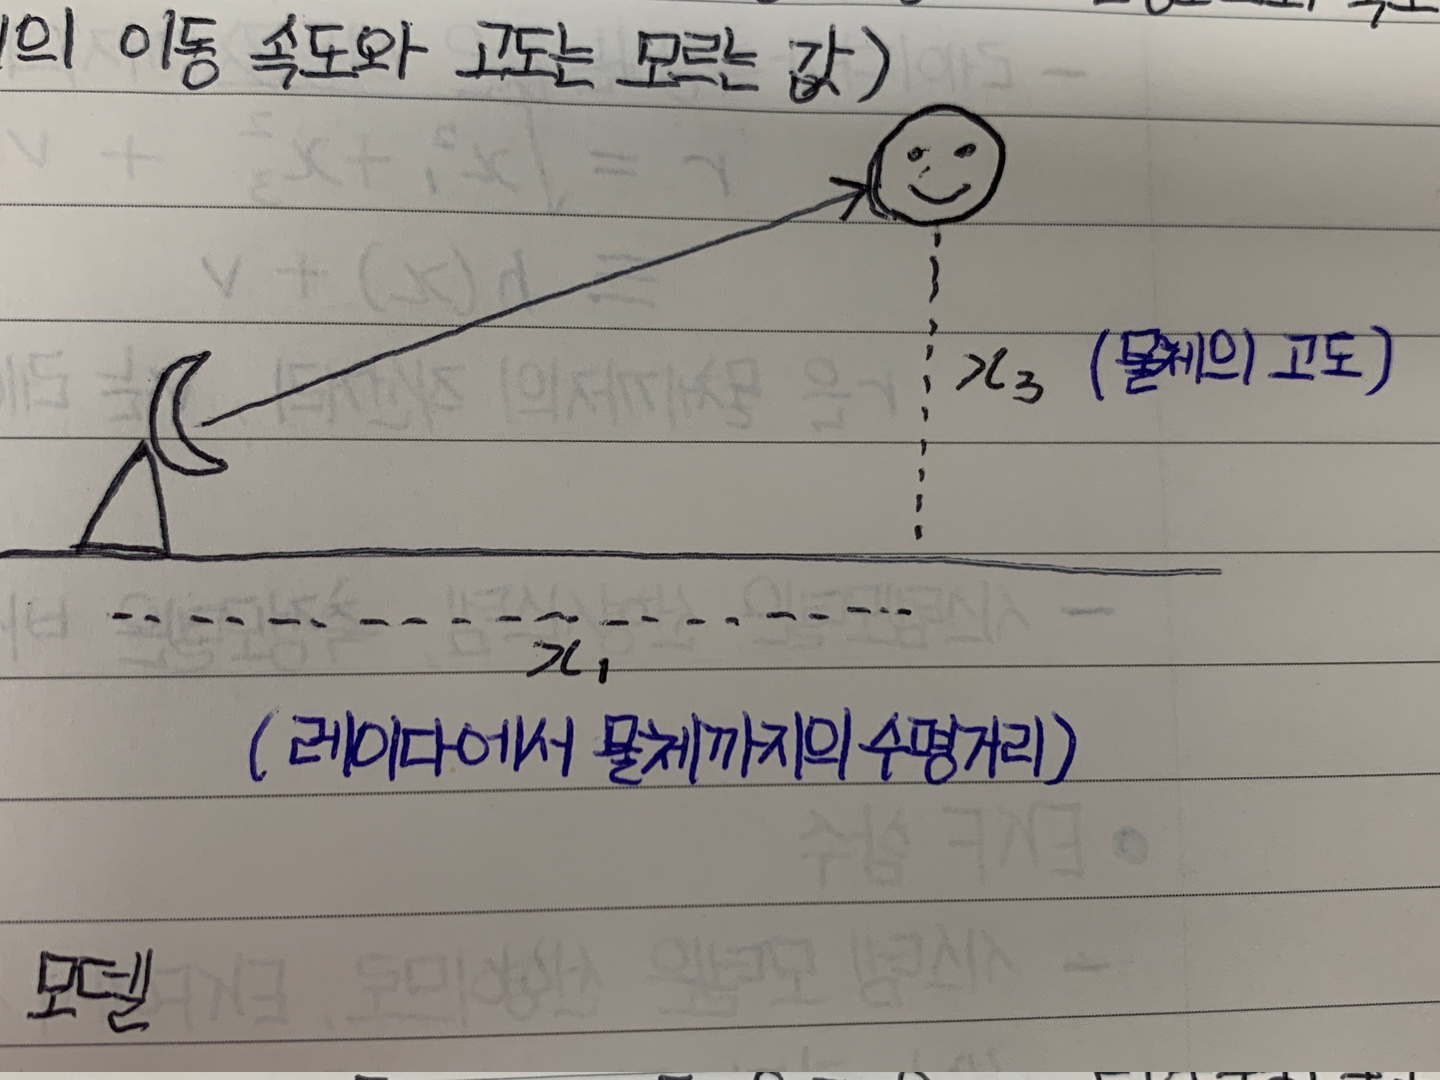

In [4]:
Image.open('./image/ch12_3.jpeg')

### 시스템 모델
- 시스템 모델이 의미하는 바
    1. 첫번째 식은 수평거리와 이동속도 관계를 반영 (수평거리의 변화율(미분)이 이동속도)
    2. 두번째와 세번째 식은 이동속도와 고도가 일정하다는 것을 수학적으로 표현
    
### 측정 모델
- 레이다가 측정하는 것은 이동물체까지의 직선거리
    - r은 물체까지의 직선거리, v는 레이다의 측정잡음
- 시스템 모델은 선형시스템, 측정모델은 비선형시스템인 문제

### EKF 함수
- 시스템모델은 선형이므로, EKF에서 상태변수 예측 시 선형칼만필터의 수식 사용
- [그림 12-1]의 EKF는 이산시스템 알고리즘이므로, 구현 시에는 시스템모델도 이산시스템으로 바꿔주어야 함
- 측정모델은 비선형이므로, 행렬 H는 야코비안을 계산해야 함

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

np.random.seed(0)

In [6]:
def get_radar(xpos_pred):
    """레이다로 측정된 고도와 직선거리를 반환해줌"""
    xvel_w = np.random.normal(0, 5)   # xvel_w: 이동거리의 시스템 잡음 [m/s].
    xvel_true = 100 + xvel_w          # xvel_true: 이동거리의 참값 [m/s].

    ypos_w = np.random.normal(0, 10)  # ypos_w: 고도의 시스템 잡음 [m].
    ypos_true = 1000 + ypos_w         # ypos_true: 고도의 참값 [m].

    xpos_pred = xpos_pred + xvel_true * dt                     # xpos_pred: 이동거리 예상치 [m].

    rpos_v = xpos_pred * np.random.normal(0, 0.05)             # rpos_v: 레이다의 측정잡음.
    rpos_meas = np.sqrt(xpos_pred**2 + ypos_true**2) + rpos_v  # r: 측정 거리 [m] (observable).

    return rpos_meas, xpos_pred

In [7]:
# 야코비안 계산
def Ajacob_at(x_esti):
    return A

def Hjacob_at(x_pred):
    H[0][0] = x_pred[0] / np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    H[0][1] = 0
    H[0][2] = x_pred[2] / np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    return H

In [8]:
# 비선형시스템 계산 (측정모델)
def fx(x_esti):
    return A @ x_esti

def hx(x_pred):
    z_pred = np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    return np.array([z_pred])

In [9]:
def extended_kalman_filter(z_meas, x_esti, P):
    """Extended Kalman Filter Algorithm."""
    # (1) Prediction.
    A = Ajacob_at(x_esti)
    x_pred = fx(x_esti)
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    H = Hjacob_at(x_pred)
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - hx(x_pred))

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P

In [10]:
# Input parameters.
time_end = 20
dt = 0.05

In [11]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.eye(3) + dt * np.array([[0, 1, 0],
                               [0, 0, 0],
                               [0, 0, 0]])
H = np.zeros((1, 3))
Q = np.array([[0, 0, 0],
              [0, 0.001, 0],
              [0, 0, 0.001]])
R = np.array([[10]])

# Initialization for estimation.
x_0 = np.array([0, 90, 1100])  # [horizontal position, horizontal velocity, vertical position].
P_0 = 10 * np.eye(3)

In [12]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)
rpos_esti_save = np.zeros(n_samples)
xvel_esti_save = np.zeros(n_samples)
rpos_meas_save = np.zeros(n_samples)

In [13]:
xpos_pred = 0
x_esti, P = None, None
for i in range(n_samples):
    z_meas, xpos_pred = get_radar(xpos_pred)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = extended_kalman_filter(z_meas, x_esti, P)

    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]
    rpos_esti_save[i] = np.sqrt(x_esti[0]**2 + x_esti[2]**2)
    xvel_esti_save[i] = x_esti[1]
    rpos_meas_save[i] = z_meas

Text(0, 0.5, 'Horizontal Velocity [m/s]')

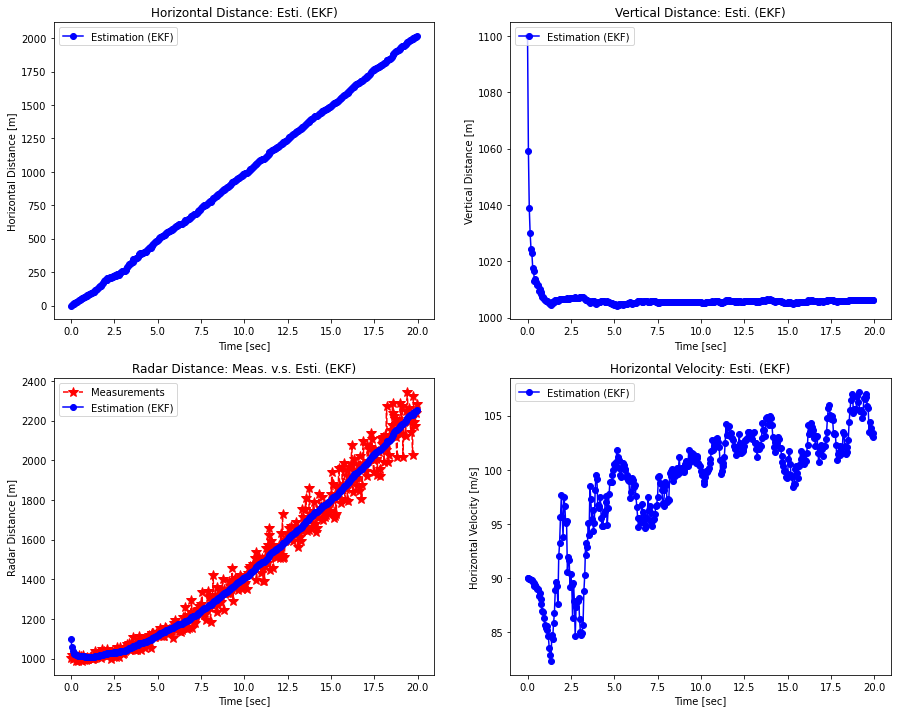

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axes[0, 0].plot(time, xpos_esti_save, 'bo-', label='Estimation (EKF)')
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_title('Horizontal Distance: Esti. (EKF)')
axes[0, 0].set_xlabel('Time [sec]')
axes[0, 0].set_ylabel('Horizontal Distance [m]')

axes[0, 1].plot(time, ypos_esti_save, 'bo-', label='Estimation (EKF)')
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_title('Vertical Distance: Esti. (EKF)')
axes[0, 1].set_xlabel('Time [sec]')
axes[0, 1].set_ylabel('Vertical Distance [m]')

axes[1, 0].plot(time, rpos_meas_save, 'r*--', label='Measurements', markersize=10)
axes[1, 0].plot(time, rpos_esti_save, 'bo-', label='Estimation (EKF)')
axes[1, 0].legend(loc='upper left')
axes[1, 0].set_title('Radar Distance: Meas. v.s. Esti. (EKF)')
axes[1, 0].set_xlabel('Time [sec]')
axes[1, 0].set_ylabel('Radar Distance [m]')

axes[1, 1].plot(time, xvel_esti_save, 'bo-', label='Estimation (EKF)')
axes[1, 1].legend(loc='upper left')
axes[1, 1].set_title('Horizontal Velocity: Esti. (EKF)')
axes[1, 1].set_xlabel('Time [sec]')
axes[1, 1].set_ylabel('Horizontal Velocity [m/s]')


- 이동거리 예측 (왼쪽 첫번째 그림)
- 고도 예측 (오른쪽 첫번째 그림) : 실제 고도의 평균은 1000m, 10%의 오차가 있었지만 발산하지 않음
- 레이다가 측정한 직선거리와 추정거리 비교 (왼쪽 두번째 그림) : 잡음이 거의 제거되었고, 측정거리변화도 잘 반영됨
- 이동속도 예측 (오른쪽 두번째 그림) : 실제속도는 100m/s, 시간이 지날수록 속도 추정값이 명목 속도 근방으로 수렴